<a href="https://colab.research.google.com/github/ftcelepcikay/Sequences-Time-Series/blob/master/S%2BP_Week_4_Exercise_Question.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [0]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [0]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-05-22 12:20:55--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.002s  

2020-05-22 12:20:56 (28.5 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



In [0]:
# FTC note: 1st way of reading csv using pd
import pandas as pd
df = pd.read_csv('/tmp/daily-min-temperatures.csv')
df.head


<bound method NDFrame.head of             Date  Temp
0     1981-01-01  20.7
1     1981-01-02  17.9
2     1981-01-03  18.8
3     1981-01-04  14.6
4     1981-01-05  15.8
...          ...   ...
3645  1990-12-27  14.0
3646  1990-12-28  13.6
3647  1990-12-29  13.5
3648  1990-12-30  15.7
3649  1990-12-31  13.0

[3650 rows x 2 columns]>

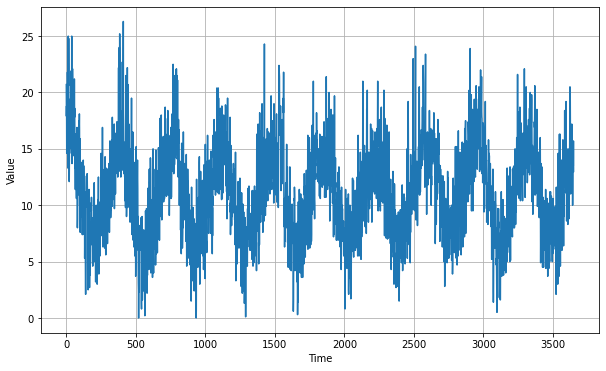

In [0]:
time = df.index.to_numpy()
series = df.Temp.to_numpy()
plt.figure(figsize=(10, 6))
plot_series(time, series)

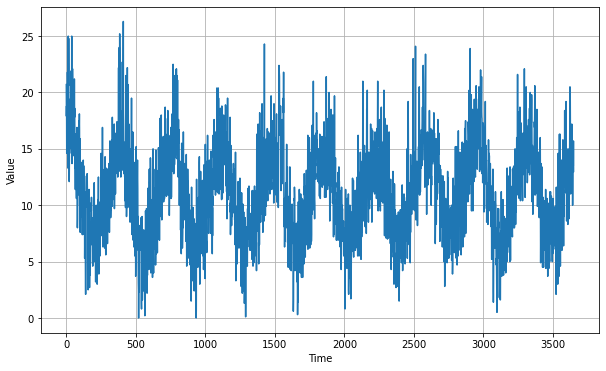

In [0]:
# FTC note: 2nd way of reading csv using csv.reader
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)  # it is not reader(next)
  time = 0
  for row in reader:
    temp = float(row[1]) # delimiter splits the string into substrings [Date] and [Temp]
    temps.append(temp)
    time_step.append(time)
    time += 1

# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [0]:
# FTC note: dimesion is expanded in this helper function.
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
# FTC note: this helper function is used for prediction.
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
 tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 0s 30ms/step - loss: 24.1389 - mae: 24.6346 - lr: 1.0000e-08
Epoch 2/100
10/10 [==============================] - 0s 24ms/step - loss: 23.8900 - mae: 24.3855 - lr: 1.1220e-08
Epoch 3/100
10/10 [==============================] - 0s 24ms/step - loss: 23.5626 - mae: 24.0581 - lr: 1.2589e-08
Epoch 4/100
10/10 [==============================] - 0s 25ms/step - loss: 23.2269 - mae: 23.7227 - lr: 1.4125e-08
Epoch 5/100
10/10 [==============================] - 0s 26ms/step - loss: 22.8968 - mae: 23.3923 - lr: 1.5849e-08
Epoch 6/100
10/10 [==============================] - 0s 33ms/step - loss: 22.5721 - mae: 23.0678 - lr: 1.7783e-08
Epoch 7/100
10/10 [==============================] - 0s 30ms/step - loss: 22.2368 - mae: 22.7325 - lr: 1.9953e-08
Epoch 8/100
10/10 [==============================] - 0s 30ms/step - loss: 21.8822 - mae: 22.3778 - l

[1e-08, 0.0001, 0, 60]

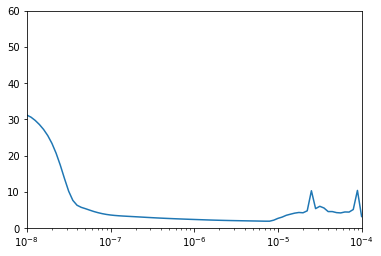

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])


optimizer = tf.keras.optimizers.SGD(lr=7e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=100)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/100
25/25 [==============================] - 0s 12ms/step - loss: 10.1614 - mae: 10.6464
Epoch 2/100
25/25 [==============================] - 0s 13ms/step - loss: 2.5330 - mae: 2.9952
Epoch 3/100
25/25 [==============================] - 0s 12ms/step - loss: 1.9464 - mae: 2.4005
Epoch 4/100
25/25 [==============================] - 0s 14ms/step - loss: 1.8223 - mae: 2.2727
Epoch 5/100
25/25 [==============================] - 0s 13ms/step - loss: 1.7574 - mae: 2.2064
Epoch 6/100
25/25 [==============================] - 0s 13ms/step - loss: 1.7197 - mae: 2.1675
Epoch 7/100
25/25 [==============================] - 0s 11ms/step - loss: 1.6953 - mae: 2.1420
Epoch 8/100
25/25 [==============================] - 0s 12ms/step - loss: 1.6818 - mae: 2.1277
Epoch 9/100
25/25 [==============================] - 0s 14ms/step - loss: 1.6678 - mae: 2.1135
Epoch 10/100
25/25 [==============================] - 0s 12ms/step - loss: 1.6597 - mae: 2.1051
Epoch 11/100
25/25 [===========================

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

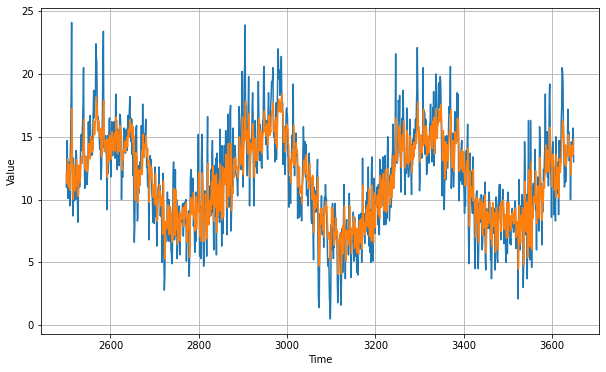

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.7990301

In [0]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[11.996249 11.291159 12.164264 ... 13.548923 13.60156  14.761917]
